In [1]:
import pandas as pd
import nivapy3 as nivapy
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [2]:
# Connect to db
eng = nivapy.da.connect()

Connection successful.


# Test Prophet with ICPW data

A quick test of Facebook's [Prophet](https://facebook.github.io/prophet/) algorithm, as applied to ICPW.

## 1. Get data

In [3]:
# Select project
prj_grid = nivapy.da.select_resa_projects(eng)
prj_grid

582 projects in the RESA database.


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [4]:
# Select project
prj_df = prj_grid.get_selected_df()
prj_df

,project_id,project_number,project_name,contact_person,project_description
424,2120,None,ICPWaters NO,None,None


In [5]:
# Get stations for these projects
stn_df = nivapy.da.select_resa_project_stations(prj_df, eng)
print (len(stn_df), 'stations associated with the selected projects.')
stn_df.head()

5 stations associated with the selected projects.


,station_id,station_code,station_name,latitude,longitude,altitude
0,108,LAE01,"Langtjern, utlÃ¸p",60.372460,9.726660,516
1,221,BIE01,Birkenes,58.385426,8.241721,190
2,12080,STE01,Storgama v. dam,59.052333,8.653606,587
3,12081,KAE01,KÃ¥rvatn feltforskningsstasjon,62.782883,8.893443,210
4,12082,DALELV,Dalelv,69.684738,30.386154,10


In [6]:
# Map
nivapy.spatial.quickmap(stn_df, 
                        popup='station_code',
                        aerial_imagery=True)

In [7]:
# Get available parameters
st_dt = '1970-01-01'
end_dt = '2019-01-01'
par_grid = nivapy.da.select_resa_station_parameters(stn_df,
                                                    st_dt,
                                                    end_dt,
                                                    eng)
par_grid

104 parameters available for the selected stations and dates.


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [8]:
# Select relevant parameters
par_df = par_grid.get_selected_df()
par_df

,parameter_id,parameter_name,unit
0,3,ALK,mmol/l
11,11,Ca,mg/l
47,13,Mg,mg/l
52,5,NO3-N,µg/l N
51,49,NH4-N,µg/l N
36,12,K,mg/l
53,14,Na,mg/l
15,7,Cl,mg/l
71,8,SO4,mg/l
79,6,TOC,mg C/l


In [9]:
# Get chem
wc_df, dup_df = nivapy.da.select_resa_water_chemistry(stn_df,
                                                      par_df,
                                                      st_dt,
                                                      end_dt,
                                                      eng,
                                                      drop_dups=True,
                                                      lod_flags=False)
wc_df.head()

WARNING
The database contains unexpected duplicate values for some station-date-parameter combinations.
Only the most recent values will be used, but you should check the repeated values are not errors.
The duplicated entries are returned in a separate dataframe.



,station_id,station_code,station_name,sample_date,depth1,depth2,ALK_mmol/l,Ca_mg/l,Cl_mg/l,K_mg/l,Mg_mg/l,NH4-N_µg/l N,NO3-N_µg/l N,Na_mg/l,SO4_mg/l,TOC_mg C/l,pH_
,,,,,,,,,,,,,,,,,
0,108,LAE01,"Langtjern, utlÃ¸p",1972-09-01 00:00:00,0.0,0.0,0.0,1.30,NaN,NaN,NaN,NaN,10.0,0.60,NaN,NaN,5.04
1,108,LAE01,"Langtjern, utlÃ¸p",1972-12-11 00:00:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,4.92
2,108,LAE01,"Langtjern, utlÃ¸p",1973-04-04 15:15:00,0.0,0.0,0.0,1.31,NaN,0.13,0.27,NaN,40.0,0.67,NaN,NaN,4.80
3,108,LAE01,"Langtjern, utlÃ¸p",1973-04-05 17:40:00,0.0,0.0,0.0,1.32,NaN,0.15,0.27,NaN,40.0,0.69,NaN,NaN,4.69
4,108,LAE01,"Langtjern, utlÃ¸p",1973-04-06 12:00:00,0.0,0.0,0.0,1.31,NaN,0.12,0.27,NaN,30.0,0.67,NaN,NaN,4.67


In [10]:
# Save for later
wc_df.to_csv('icpw_norway_chem.csv', index=False, encoding='utf-8')

In [11]:
# Load saved data
wc_df = pd.read_csv('icpw_norway_chem.csv', encoding='utf-8')
wc_df['sample_date'] = pd.to_datetime(wc_df['sample_date'])

In [12]:
# Choose site
stn = 'BIE01'

# Resample to monthly for chosen site
df = wc_df.query('station_code == @stn')
df.index = df['sample_date']
df = df.resample('M').mean().reset_index()
df.head()

,sample_date,station_id,depth1,depth2,ALK_mmol/l,Ca_mg/l,Cl_mg/l,K_mg/l,Mg_mg/l,NH4-N_µg/l N,NO3-N_µg/l N,Na_mg/l,SO4_mg/l,TOC_mg C/l,pH_
0,1972-07-31,221.0,0.0,0.0,NaN,1.590000,NaN,NaN,NaN,NaN,45.833333,2.650833,NaN,NaN,5.185833
1,1972-08-31,221.0,0.0,0.0,NaN,1.313871,NaN,NaN,NaN,NaN,44.193548,2.406129,NaN,NaN,4.916452
2,1972-09-30,221.0,0.0,0.0,NaN,1.534333,NaN,NaN,NaN,NaN,64.000000,2.843667,NaN,NaN,5.233333
3,1972-10-31,221.0,0.0,0.0,NaN,1.773387,4.084375,0.437187,0.580625,NaN,121.129032,2.994677,NaN,NaN,5.510806
4,1972-11-30,221.0,0.0,0.0,NaN,1.673750,NaN,NaN,NaN,NaN,90.000000,3.021563,NaN,NaN,5.018125


## 2. Trends in TOC

In [13]:
# Get TOC
toc_df = df[['sample_date', 'TOC_mg C/l']].copy()
toc_df.columns = ['ds', 'y']
toc_df.head()

,ds,y
0,1972-07-31,NaN
1,1972-08-31,NaN
2,1972-09-30,NaN
3,1972-10-31,NaN
4,1972-11-30,NaN


In [14]:
# Fit model
m = Prophet()
m.fit(toc_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


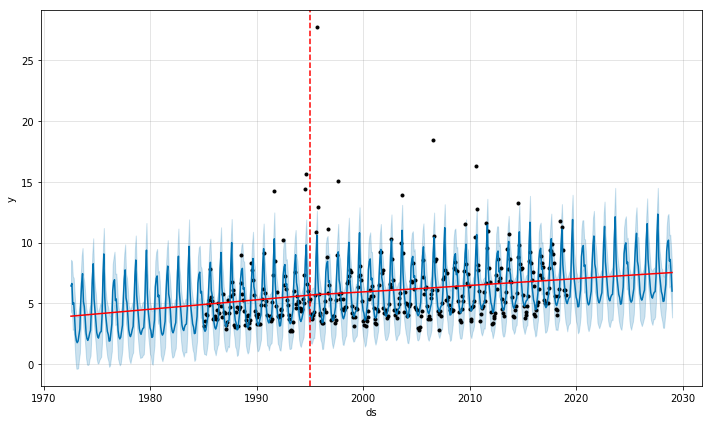

In [15]:
# Predict the next 10 years, with uncertainty
future = m.make_future_dataframe(periods=120, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), m, fcst)
#plt.savefig(stn + '_TOC.png', dpi=300)

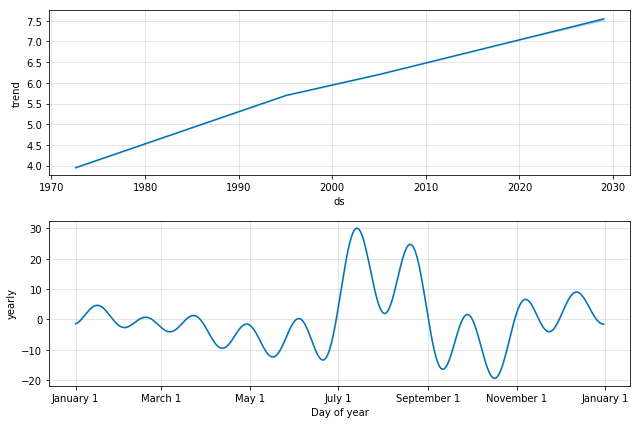

In [16]:
fig2 = m.plot_components(fcst)

The data suggests that TOC increased rapidly from 1990 to around 2000, and then continued to increase more slowly.

## 3. Trends in SO4

**Note:** This is just raw SO4 for now (i.e. not corrected in any way).

In [ ]:
# Get SO4
so4_df = df[['sample_date', 'SO4_mg/l']].copy()
so4_df.columns = ['ds', 'y']
so4_df.head()

In [ ]:
# Fit model
so4_df['cap'] = so4_df['y'].max()
m = Prophet(growth='logistic')
m.fit(so4_df)

In [ ]:
# Predict the next 10 years, with uncertainty
future = m.make_future_dataframe(periods=120, freq='M')
future['cap'] = so4_df['y'].max()
fcst = m.predict(future)
fig = m.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), m, fcst)
plt.savefig(stn + '_SO4.png', dpi=300)

Based on the above plots, SO4 at site `'CA01'` declined steadily until about 2004, then started to decrease more rapidly.